This notebook is for preprocessing ZebraBox xls data to the output that is accepted by sleep analysis (matlab).

Open xls file in Excel and save as CSV, in the same folder with the same name convention + the extension.

TODO

Convert xls to CSV
pip install xlrd


Incorporate genotype files
pip install openpyxl

In [12]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 1

%aimport b6_epilepsies 
import b6_epilepsies as b6 #.py file in the same dir as this .ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:

# Define input variables
date   = "241030"
box1   = "16"
box2   = "17"
exp    = "WT_PTZ"
export = False
    
data      = b6.MiddurData(date, box1, box2, exp, export)
middur_df = data.prepare_raw_data()

middur_df.head()

# export_to_txt(middur_df, date, path)

Finished.


[autoreload of b6_epilepsies failed: Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/homebrew/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/opt/homebrew/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/opt/homebrew/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/opt/homebrew/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 309, in update_function
    setattr(old, name, getattr(new, name))
ValueError: __init__() requires a code object with 0 free vars,

,TIME(SECONDS),NA,FISH1,FISH2,FISH3,FISH4,FISH5,FISH6,FISH7,FISH8,...,FISH24,FISH25,FISH26,FISH27,FISH28,FISH29,FISH30,NA,NA,CLOCK
0,start,end,middur,middur,middur,middur,middur,middur,middur,middur,...,middur,middur,middur,middur,middur,middur,middur,,,
1,0,60.0,0.0,0.04,12.878,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.325,0.041,0.0,0.0,0.0,,,5.633333
2,60,120.0,1.062,0.041,7.64,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.784,0.0,0.0,0.0,0.0,,,5.65
3,120,180.0,2.238,0.0,0.0,0.0,0.0,0.18,0.0,0.0,...,0.0,0.0,5.189,0.196,0.0,0.0,0.0,,,5.666667
4,180,240.0,0.081,0.034,7.158,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.265,0.0,0.0,0.0,0.0,,,5.683333


In [18]:
import os
import pandas as pd
from datetime import timedelta

# Define input variables
date = "241030"
box1 = "16"
box2 = "17"
exp  = "WT_PTZ"

name = date + "_" + box1 + "_" + box2 + "_" + exp
path = name + "/"  # Directory where the file will be saved

# Columns to read from the CSV file
cols = ["start", "end", "animal", "stdate", "sttime", "middur"]

# Read the CSV file with specific columns, header starts at row 1, and combine 'stdate' and 'sttime'
data = pd.read_csv(path + name + ".csv", usecols=cols, low_memory=False, header=0, parse_dates=[['stdate', 'sttime']])

# Function to calculate the 'CLOCK' column
def calculate_clock(series):
    def compute_clock(start_datetime):
        reference_time = start_datetime.replace(hour=9, minute=0, second=0)
        if start_datetime < reference_time:
            reference_time -= timedelta(days=1)
        return (start_datetime - reference_time).total_seconds() / 3600
    
    return pd.concat([pd.Series([""]), series.apply(compute_clock)])

def legacy(middur_df, larvae):
    
    # Rename the 'start' and 'end' columns for compatibility
    middur_df.rename(columns={'start': 'TIME(SECONDS)', 'end': 'NA'}, inplace=True)
    
    # Create the second row after the header ('start', 'end', 'middur' repeated for each fish)
    header_row = ['start', 'end'] + ['middur'] * len(larvae)
    
    # Create a DataFrame for the additional row
    additional_row_df = pd.DataFrame([header_row], columns=middur_df.columns)
    
    # Concatenate the additional row with the original DataFrame
    final_df = pd.concat([additional_row_df, middur_df], ignore_index=True)

    # Append two blank columns, both labeled 'NA'
    final_df['NA_1'] = ""  # First blank column
    final_df['NA_2'] = ""  # Second blank column

    # Rename both columns to 'NA'
    final_df.columns = [col if col not in ['NA_1', 'NA_2'] else 'NA' for col in final_df.columns]

    return final_df

# Function to export the DataFrame as a .txt file
def export_to_txt(final_df, date, path):
    filename = os.path.join(path, f"{date}_00_DATA.csv")  # Construct the file path
    final_df.to_csv(filename, sep='\t', index=False)  # Export DataFrame to .txt with tab separators
    print(f"File saved at: {filename}")  # Confirmation message

# Get unique animals (larvae) in the dataset
larvae = data["animal"].unique()

# Initialize a dictionary to store the middur data keyed by 'FISHx'
middur_dict = {}

# Loop over each larva to extract middur data
for i, larva in enumerate(larvae):
    # Extract data for the current larva
    larvalData = data[data["animal"] == larva]
    
    # Add 'start' and 'end' only once (for the first larva)
    if i == 0: 
        middur_dict['start'] = larvalData['start'].reset_index(drop=True)
        middur_dict['end'] = larvalData['end'].reset_index(drop=True)
    
        
        # Calculate the 'CLOCK' column based on the combined 'stdate' and 'sttime'
        clock = calculate_clock(larvalData['stdate_sttime']).reset_index(drop=True)
 
    # Key the middur data by the fish name 'FISHx'
    fishName = f'FISH{i+1}'
    middur_dict[fishName] = larvalData['middur'].reset_index(drop=True)

    # If we want genotype data, uncomment the next two lines and comment out above line
    # genotype = pd.Series([fish_genotype_dict[i+1]])
    # middur_dict[fishName] = pd.concat([genotype,larvalData['middur'].reset_index(drop=True)])
 


# Convert the dictionary into a DataFrame
middur_df = pd.DataFrame(middur_dict)

#### Legacy (and a bit redundant) adjustments to make it compatible with the existing analysis ####
middur_df = legacy(middur_df, larvae)

middur_df['CLOCK'] = clock

# Display the final DataFrame with the additional header row
middur_df.head()

,TIME(SECONDS),NA,FISH1,FISH2,FISH3,FISH4,FISH5,FISH6,FISH7,FISH8,...,FISH24,FISH25,FISH26,FISH27,FISH28,FISH29,FISH30,NA,NA,CLOCK
0,start,end,middur,middur,middur,middur,middur,middur,middur,middur,...,middur,middur,middur,middur,middur,middur,middur,,,
1,0,60.0,0.0,0.04,12.878,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.325,0.041,0.0,0.0,0.0,,,5.633333
2,60,120.0,1.062,0.041,7.64,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.784,0.0,0.0,0.0,0.0,,,5.65
3,120,180.0,2.238,0.0,0.0,0.0,0.0,0.18,0.0,0.0,...,0.0,0.0,5.189,0.196,0.0,0.0,0.0,,,5.666667
4,180,240.0,0.081,0.034,7.158,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.265,0.0,0.0,0.0,0.0,,,5.683333


In [21]:
# Export the final DataFrame to a .txt file
export_to_txt(middur_df, date, path)

File saved at: 241030_16_17_WT_PTZ/241030_00_DATA.csv


In [155]:
import pandas as pd

def genotype_generator(excel_file_path):
    # Load the Excel file
    df = pd.read_excel(excel_file_path, sheet_name='Sheet1', engine='openpyxl')

    # Identify the "Comments" row, which we will use to stop processing
    comments_row_idx = df[df.iloc[:, 0].str.contains("Comments", na=False)].index
    
    if len(comments_row_idx) == 0:
        raise ValueError("Error: Could not find the row where comments start. Please ensure a row labeled 'Comments' exists.")
    
    # Exclude rows after the "Comments" row, including the "Comments" row itself
    df_cleaned = df.iloc[:comments_row_idx[0], :]

    # Further cleaning: keep only wells that contain genotypes, excluding irrelevant rows
    # Assuming we want to keep rows that have genotype values like 'het', 'hom', 'wt', and exclude others
    genotype_terms = ['het', 'hom', 'wt', 'empty', 'excluded']
    df_cleaned = df_cleaned[df_cleaned.apply(lambda row: row.str.contains('|'.join(genotype_terms), na=False).any(), axis=1)]

    return df_cleaned

# Usage example:
genotype_data_cleaned = genotype_generator(path+'241030_16_genotypeMap.xlsx')
genotype_data_cleaned

NameError: name 'path' is not defined

,start,end,FISH1,FISH2,FISH3,FISH4,FISH5,FISH6,FISH7,FISH8,...,FISH183,FISH184,FISH185,FISH186,FISH187,FISH188,FISH189,FISH190,FISH191,FISH192
0,0.0,60.000,het,het,wt,het,wt,hom,het,hom,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
0,0.0,60.000,0.0,0.0,0.0,0.0,0.04,1.478,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,60.0,120.000,0.0,0.0,0.0,0.0,0.08,9.281,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,120.0,180.000,0.0,0.0,0.157,0.0,0.242,0.803,0.0,0.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,180.0,240.000,0.0,0.0,3.32,0.04,0.0,2.801,0.04,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3182,190920.0,190980.000,0.839,4.438,0.28,2.359,0.119,2.557,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3183,190980.0,191040.000,2.481,4.047,0.0,0.039,2.039,2.64,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3184,191040.0,191100.000,0.561,3.962,0.277,1.598,2.24,2.596,0.0,1.641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3185,191100.0,191160.000,0.402,2.88,0.0,5.842,2.677,3.796,0.039,1.117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
import pandas as pd

# Load the genotype file
genotype_file_path = path+'240917_00genotype.txt'
genotype_data = pd.read_csv(genotype_file_path, sep='\t', header=None)

# Initialize an empty dictionary for genotypes, defaulting to 'unknown'
fish_genotype_dict = {fish_id: 'unknown' for fish_id in range(1, 193)}

# Process rows from the genotype file starting from the third row
for row in genotype_data.iloc[2:].itertuples(index=False):
    # Fish IDs in each of the genotype columns (wt, hom, het)
    if pd.notna(row[0]):
        fish_genotype_dict[int(float(row[0]))] = 'wt'
    if pd.notna(row[1]):
        fish_genotype_dict[int(float(row[1]))] = 'hom'
    if pd.notna(row[2]):
        fish_genotype_dict[int(float(row[2]))] = 'het'

# Display the final ordered fish genotype dictionary



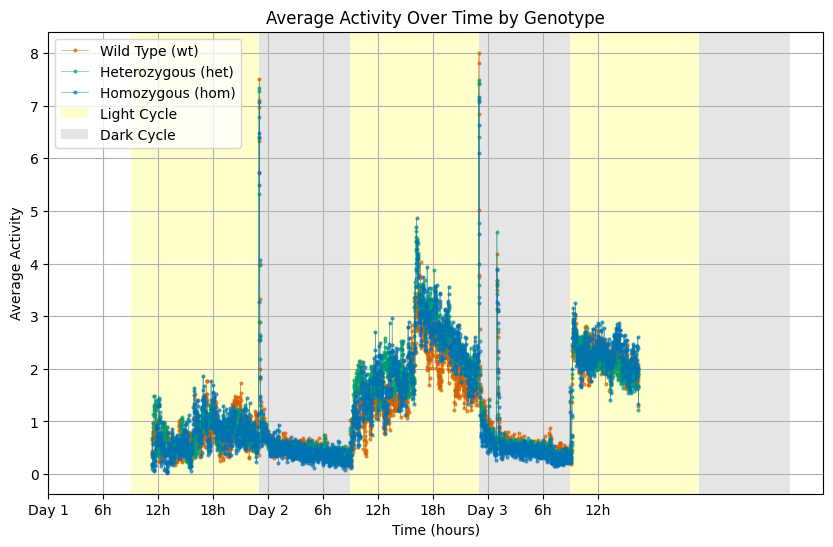

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data (replace 'your_input_file.txt' with the correct file path)
df = pd.read_csv(path+date+'_00_DATA.txt', sep='\t', header=None)

# Clean the data
# Assign headers based on the structure of the file (genotypes are in row 1)
df.columns = df.iloc[1]

# Drop the first two rows (repeated header and genotype row), and reset index
df = df.drop([0, 1]).reset_index(drop=True)

# Convert the data columns to numeric values
df_cleaned = df.apply(pd.to_numeric, errors='coerce')

# Create unique column labels for each fish based on genotype and fish index
genotype_labels = df.iloc[0, 2:].reset_index(drop=True)
unique_column_labels = [f"{genotype}_{i+1}" for i, genotype in enumerate(genotype_labels)]

# Assign these unique labels to the cleaned dataframe
df_cleaned.columns = ['start', 'end'] + unique_column_labels

# Make an explicit copy of the filtered DataFrame to avoid SettingWithCopyWarning
df_cleaned_filtered = df_cleaned.loc[:, ~df_cleaned.columns.str.contains('unknown')].copy()

# Calculate the time in hours from the start and adjust for the experiment start time (11:20:11)
time_offset_hours = 11 + 20/60 + 11/3600  # Convert 11:20:11 to hours
df_cleaned_filtered['time_hours'] = df_cleaned_filtered['start'] / 3600
df_cleaned_filtered['adjusted_time_hours'] = df_cleaned_filtered['time_hours'] + time_offset_hours

# Separate data by genotype groups
wt_data = df_cleaned_filtered.loc[:, df_cleaned_filtered.columns.str.startswith('wt')]
het_data = df_cleaned_filtered.loc[:, df_cleaned_filtered.columns.str.startswith('het')]
hom_data = df_cleaned_filtered.loc[:, df_cleaned_filtered.columns.str.startswith('hom')]

# Calculate the average for each genotype at each time point
wt_avg = wt_data.mean(axis=1)
het_avg = het_data.mean(axis=1)
hom_avg = hom_data.mean(axis=1)

# Define the light and dark cycle durations
light_duration = 14
dark_duration = 10
cycle_duration = light_duration + dark_duration  # One full cycle (24 hours)
start_time_hours = 9  # The experiment starts at 9:00 AM in hours

# Plotting the graph with light/dark cycles and reduced opacity for data points
def plot_activity_with_cycles(df_cleaned_filtered, wt_avg, het_avg, hom_avg):
    plt.figure(figsize=(10, 6))

    # Plot the data with reduced opacity
    plt.plot(df_cleaned_filtered['adjusted_time_hours'], wt_avg, label='Wild Type (wt)', 
             marker='o', markersize=2, color='#D55E00', linewidth=0.5, alpha=0.6)
    plt.plot(df_cleaned_filtered['adjusted_time_hours'], het_avg, label='Heterozygous (het)', 
             marker='o', markersize=2, color='#009E73', linewidth=0.5, alpha=0.6)
    plt.plot(df_cleaned_filtered['adjusted_time_hours'], hom_avg, label='Homozygous (hom)', 
             marker='o', markersize=2, color='#0072B2', linewidth=0.5, alpha=0.6)

    # Add labels and title
    plt.xlabel('Time (hours)')
    plt.ylabel('Average Activity')
    plt.title('Average Activity Over Time by Genotype')

    # Add shading for light and dark cycles
    max_time = df_cleaned_filtered['adjusted_time_hours'].max()
    current_time = start_time_hours

    while current_time < max_time:
        plt.axvspan(current_time, current_time + light_duration, facecolor='yellow', alpha=0.2, label='Light Cycle' if current_time == start_time_hours else "")
        plt.axvspan(current_time + light_duration, current_time + cycle_duration, facecolor='gray', alpha=0.2, label='Dark Cycle' if current_time == start_time_hours else "")
        current_time += cycle_duration

    # Set x-ticks to show days and add ticks for every 6 hours
    plt.xticks(range(0, int(df_cleaned_filtered['adjusted_time_hours'].max()) + 1, 6), 
               labels=[f"Day {i // 24 + 1}" if i % 24 == 0 else f"{i % 24}h" 
                       for i in range(0, int(df_cleaned_filtered['adjusted_time_hours'].max()) + 1, 6)])

    # Add a grid for better visualization
    plt.grid(True)

    # Display the plot with a legend
    plt.legend()
    plt.show()

# Call the function to generate the plot
plot_activity_with_cycles(df_cleaned_filtered, wt_avg, het_avg, hom_avg)